In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import cma
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa
from cma import CMAEvolutionStrategy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Colebrook-White equation function to solve for friction factor f
def colebrook(Re, ks_D):
    # Initial guess for friction factor (Blasius correlation for smooth pipe)
    f = 0.079 / Re**0.25
    # Iterative solution for Colebrook-White equation
    for i in range(100):
        f_new = 1 / (-1 * np.log10((ks_D / 3.7) + (5.02 / (Re * np.sqrt(f)))))
        if abs(f_new - f) < 1e-6:  # Convergence criterion
            f = f_new
            break
        f = f_new
    Cf = f 
    return Cf

# Define the sample size
n_samples = 20000  # or any desired number
mu        = 0.001  # Example constant value in Pa.s
## IF REYNOLDS NUMBER AND RELATIVE ROUGHNESS ARE LOG UNIFORM DISTRIBUTED
log_Re                 = np.random.uniform(3, 5, n_samples)  
log_relative_roughness = np.random.uniform(-8, -0.7, n_samples)  
Re                     = 10**log_Re
relative_roughness     = 10**log_relative_roughness
rho = 200  # Example constant density (kg/m^3)
D   = np.random.uniform(1, 10, n_samples)
k   = relative_roughness * D  # Roughness height (m)
U   = (Re * mu) / (rho * D)  # Velocity (m/s)
Cf  = np.zeros(n_samples)
for i in range(n_samples):
    Cf[i] = colebrook(Re[i], relative_roughness[i])
print(f'Relative roughness range: {relative_roughness.min()} - {relative_roughness.max()}')
print(f'Reynolds number range: {Re.min()} - {Re.max()}')    

Relative roughness range: 1.0008828143436154e-08 - 0.1993559277277221
Reynolds number range: 1000.2099644277114 - 99984.22429989158


In [3]:
X              = np.column_stack((U, rho * np.ones(n_samples), D, k, mu * np.ones(n_samples)))
# Output matrix Y (Skin Friction Coefficient Cf)
Y              = Cf.reshape(-1, 1)
D_in           = np.matrix('1 -3 1 1 -1; -1 0 0 0 -1; 0 1 0 0 1')
variables_tauw = ['u', '\\rho', 'D', 'k','\\mu'];
num_input      = 2

In [4]:
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows   = np.shape(D_in)[0]
num_cols   = np.shape(D_in)[1]
# Function to calculate basis matrices
def calc_basis(D_in, col_range):
    num_rows   = np.shape(D_in)[0]
    num_cols   = np.shape(D_in)[1]
    Din1, Din2 = D_in[:, :num_rows], D_in[:, num_rows:]
    basis_matrices = []
    for i in range(col_range):
        x2 = np.zeros((col_range, 1))
        x2[i, 0] = -1
        x1 = -inv(Din1) * Din2 * x2
        basis_matrices.append(np.vstack((x1, x2)))
    return np.asmatrix(np.array(basis_matrices))
# Generate basis matrices
num_basis      = D_in.shape[1] -matrix_rank(D_in)
basis_matrices = calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

Rank of D_in: 3
D_in matrix:
 [[ 1 -3  1  1 -1]
 [-1  0  0  0 -1]
 [ 0  1  0  0  1]]
Basis vectors:
matrix([[ 0.,  0.,  1., -1.,  0.],
        [ 1.,  1.,  1.,  0., -1.]])


In [5]:
def calc_pi(a, basis_matrices,X):
    coef_pi = np.dot(a, basis_matrices)  # Computes the weighted sum of basis matrices
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat

def calc_pi_omega(coef_pi, X):
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
        
    return pi_mat


In [6]:
def MI_d_binning(input, output, num_bins):
    #Calculate the mutual information between two matrices X and Y using histograms.
    #Fast! But not Accurate! Using it for approximation.
    #Parameters:
    #X (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #Y (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #num_bins (int): Number of bins for the histogram
    #Returns:
    #float: The mutual information between X and Y.

    mi = entropy_bin(input, num_bins) + entropy_bin(output, num_bins) - entropy_bin(np.hstack([input, output]), num_bins)
    return mi

def entropy_bin(X, num_bins):        
    N, D = X.shape
    bins = [num_bins] * D
    hist, _ = np.histogramdd(X, bins=bins)
    hist = hist / np.sum(hist)  # Normalize to get probabilities
    positive_indices = hist > 0
    return -np.sum(hist[positive_indices] * np.log(hist[positive_indices]))


def entropy_dis_d(data):
    """
    This function calculates the discrete entropy of d-dimensional data.

    Parameters:
    data (numpy.ndarray): A matrix where each row represents a d-dimensional data point.

    Returns:
    float: The calculated discrete entropy.
    """
    # Ensure data is in the correct format
    if not isinstance(data, np.ndarray) or len(data.shape) != 2:
        raise ValueError('Data must be a 2D matrix')
    # Count the frequency of each unique row in the data
    unique_rows, indices = np.unique(data, axis=0, return_inverse=True)
    freq = np.bincount(indices)
    # Calculate probabilities
    probabilities = freq / data.shape[0]
    # Calculate entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy

def KraskovMI1_nats( x, y, k : int = 1 ):
    '''Compute the mutual information using the Kraskov estimator (approach
    1 in Kraskov et al. (2004))
    Parameters
        x:  np.ndarray
            [ N, dim_x ] First variable of dimension "dim_x" with "N" samples
            per dimension
        y:  np.ndarray
            [ N, dim_x ] second variable of dimension "dim_x" with "N" samples
            per dimension
        
        k:  int
            Nearest-neighbor ( >= 1 )
    '''

    N, dim = x.shape
    V = np.hstack([ x, y ])
    # Init query tree
    kdtree = scispa.KDTree( V )
    ei, _ = kdtree.query( V, k + 1, p = np.infty)
    # infty norm is gonna give us the maximum distance (x-dir or y-dir)
    dM = ei[:,-1]
    kdtree_x = scispa.KDTree( x )
    kdtree_y = scispa.KDTree( y )
    nx = kdtree_x.query_ball_point( x, dM , p = np.infty, return_length = True)
    ny = kdtree_y.query_ball_point( y, dM , p = np.infty, return_length = True)
    # we do not add + 1 because it is accounted in query_ball_point
    ave = ( scis.psi( nx ) + scis.psi( ny ) ).mean()

    return scis.psi(k) - ave + scis.psi(N)

In [7]:
def MI_input_output(para,basis_matrices,X,Y,num_basis,num_inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')  # Treat warnings as errors
        a_list = [tuple(para[i*num_basis:(i+1)*num_basis]) for i in range(num_inputs)]
        try:
            pi_list = [calc_pi(a, basis_matrices, X) for a in a_list]
            pi = np.column_stack(pi_list)
        except RuntimeWarning:
            return random.uniform(1e6, 1e10)  # Return a large positive value in case of RuntimeWarning
    
    if np.any(np.isnan(pi)):
        return random.uniform(1e6, 1e10)  # Return a large positive value
    
    Y = Y.reshape(-1, 1)
    MI = MI_d_binning(np.array(pi), np.array(Y), 20)
    #MI = KraskovMI1_nats(np.array(pi), np.array(Y), 5)

    return -MI

In [8]:
num_para = num_basis*num_input
print('num of paraters:',num_para)
lower_bounds = [-2] * num_para  
upper_bounds = [2] * num_para 
bounds = [lower_bounds, upper_bounds]
options = {
    'bounds': bounds,
    'maxiter': 50000,  # maximum number of iterations
    'tolx': 1e-4,     # tolerance in solution variability
    'tolfun': 1e-4,   # tolerance in function value changes
    'popsize': 100,
}
es = CMAEvolutionStrategy([0.1] * num_para, 0.5,options)
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [MI_input_output(x,basis_matrices,X,Y,num_basis,num_input) for x in solutions])
    es.disp()
es.result_pretty()
optimized_params = es.result.xbest
optimized_MI     = es.result.fbest
print('Optimized_params',optimized_params)
print('Optimized_MI',optimized_MI)

num of paraters: 4
(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 4 (seed=879433, Mon Nov  4 18:19:19 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    100 -1.864437462390472e+00 1.0e+00 5.39e-01  4e-01  6e-01 0:00.5
    2    200 -2.022089180766994e+00 1.7e+00 5.32e-01  3e-01  5e-01 0:01.0
    3    300 -1.920653352946335e+00 2.2e+00 5.09e-01  2e-01  4e-01 0:01.5
    9    900 -2.196657524066428e+00 9.6e+00 5.94e-01  6e-02  3e-01 0:04.7
   17   1700 -2.254175604750911e+00 2.4e+01 1.43e+00  4e-03  1e-01 0:08.7
   27   2700 -2.280539502638780e+00 2.9e+01 1.39e+00  9e-04  1e-02 0:13.9
   39   3900 -2.283974314391292e+00 4.5e+01 1.60e+00  5e-05  2e-03 0:19.9
   53   5300 -2.284928708756361e+00 2.5e+01 2.51e+00  8e-06  9e-05 0:27.3
termination on tolx=0.0001
final/bestever f-value = -2.284929e+00 -2.284929e+00 after 5300/5269 evaluations
incumbent solution: [-0.002024755033779063, -0.36656971106152353, -0.372710237579176, -0.01830455841095474]
std devi

In [9]:
a_list = [tuple(np.round(optimized_params[i*num_basis:(i+1)*num_basis],1)) for i in range(num_input)]
a_list[0], a_list[1] = a_list[1], a_list[0]
print(a_list)

coef_pi_list = [np.dot(a, basis_matrices) for a in a_list]
normalized_coef_pi_list = []
for coef_pi in coef_pi_list:
    max_abs_value = np.max(np.abs(coef_pi))  
    normalized_coef_pi = coef_pi / max_abs_value  
    normalized_coef_pi_list.append(normalized_coef_pi)
for i, normalized_coef_pi in enumerate(normalized_coef_pi_list):
    print(f'coef_pi{i+1}', normalized_coef_pi)
input_list = [calc_pi_omega(np.array(omega), X) for omega in normalized_coef_pi_list]
input_tauw = np.column_stack(input_list)

[(-0.4, -0.0), (-0.0, -0.4)]
coef_pi1 [[ 0.  0. -1.  1.  0.]]
coef_pi2 [[-1. -1. -1.  0.  1.]]


In [10]:
tauw_lab = []
qw_lab   = []
omega_tauw = np.array(normalized_coef_pi_list)
omega_tauw = np.array(omega_tauw).reshape(-1, len(variables_tauw))
def create_labels(omega, variables):
    labels = []
    for row in omega:
        positive_part = ''
        negative_part = ''
        for i, value in enumerate(row):
            if value > 0:
                if positive_part == '':
                    positive_part = f"{variables[i]}^{{{value}}}"
                else:
                    positive_part += f" \\cdot {variables[i]}^{{{value}}}"
            elif value < 0:
                if negative_part == '':
                    negative_part = f"{variables[i]}^{{{-value}}}"
                else:
                    negative_part += f" \\cdot {variables[i]}^{{{-value}}}"
        if negative_part == '':
            labels.append(f"${positive_part}$")
        elif positive_part == '':
            labels.append(f"$\\frac{{1}}{{{negative_part}}}$")
        else:
            labels.append(f"$\\frac{{{positive_part}}}{{{negative_part}}}$")
    return labels

tauw_lab = create_labels(omega_tauw, variables_tauw)
# Print the labels
for j, label in enumerate(tauw_lab):
    print(f'tauw_lab[{j}] = {label}')

tauw_lab[0] = $\frac{k^{1.0}}{D^{1.0}}$
tauw_lab[1] = $\frac{\mu^{1.0}}{u^{1.0} \cdot \rho^{1.0} \cdot D^{1.0}}$


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


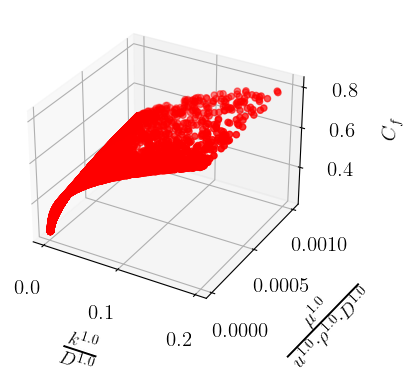

In [11]:
fig = plt.figure(figsize=(4, 4))
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['text.usetex'] = True  
ax = fig.add_subplot(111, projection='3d')
ax.scatter(input_tauw[:, 0], input_tauw[:, 1], Y, c='r', marker='o')
def prepare_label(label):
    if '$' in label:
        return r'{}'.format(label)
    return label
ax.set_xlabel(tauw_lab[0], fontsize=20, labelpad=20)  # Increase labelpad as needed
ax.set_ylabel(tauw_lab[1], fontsize=20, labelpad=25)
ax.set_zlabel(r'$C_f$', fontsize=15, labelpad=20)

ax.xaxis.set_tick_params(width=1, labelsize=15)
ax.yaxis.set_tick_params(width=1, labelsize=15)
ax.zaxis.set_tick_params(width=1, labelsize=15)
ax.tick_params(axis='both', which='major', labelsize=15, pad=10)
ax.grid(True)  
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.savefig('roughness_dimensionless.png', dpi=300, bbox_inches='tight')
plt.savefig('roughness_dimensionless.eps', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


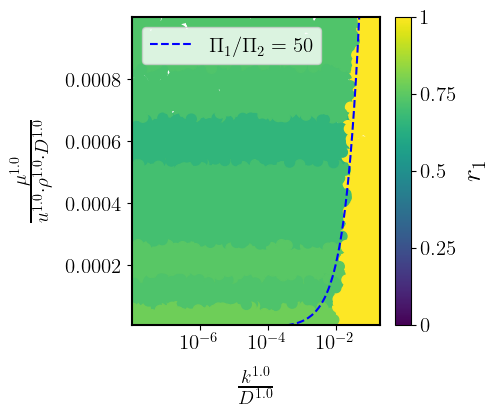

In [12]:
def partition_space(X, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    regions = kmeans.fit_predict(X)
    return regions

def analyze_regions(X1, X2, Y, regions):
    ratio_X1 = np.zeros_like(X1)  
    ratio_X2 = np.zeros_like(X2)  
    results = []
    for region in np.unique(regions):
        region_indices = (regions == region)
        X1_region = X1[region_indices]
        X2_region = X2[region_indices]
        Y_region = Y[region_indices]
        # Calculate mutual information
        mi_X1_Y = KraskovMI1_nats(X1_region.reshape(-1, 1), Y_region, 5)
        mi_X2_Y = KraskovMI1_nats(X2_region.reshape(-1, 1), Y_region, 5)
        mi_X1_X2_Y = KraskovMI1_nats(np.hstack([X1_region.reshape(-1, 1), X2_region.reshape(-1, 1)]), Y_region, 5)
        ratio_X1_region = mi_X1_Y / mi_X1_X2_Y if mi_X1_X2_Y != 0 else 0
        ratio_X2_region = mi_X2_Y / mi_X1_X2_Y if mi_X1_X2_Y != 0 else 0
        ratio_X1[region_indices] = ratio_X1_region 
        ratio_X2[region_indices] = ratio_X2_region
        
        threshold = 0.9
        if ratio_X1_region > threshold:
            result = "X1"
        elif ratio_X2_region > threshold:
            result = "X2"
        else:
            result = "Both"
        results.append((region, result))
    return results, ratio_X1, ratio_X2


    
def plot_ratio_X1(X1, X2, ratio_X1, tauw_lab):
    plt.figure(figsize=(4, 4))
    scatter = plt.scatter(X1, X2, c=ratio_X1, cmap='viridis', s=50, vmin=0, vmax=1)
    plt.rcParams['font.family'] = 'Times New Roman'  
    plt.rcParams['text.usetex'] = True  
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.xlabel(tauw_lab[0], fontsize=20, labelpad=10)  
    plt.ylabel(tauw_lab[1], fontsize=20, labelpad=10)
    plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    cbar = plt.colorbar(scatter)
    cbar.set_label('$r_1$', fontsize=20)
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1]) 
    cbar.set_ticklabels(['0', '0.25', '0.5', '0.75', '1'])  
    cbar.ax.tick_params(labelsize=15) 
    x_vals = np.linspace(np.min(X1), np.max(X1), 1000)
    y_vals_100 = x_vals / 50
    plt.plot(x_vals, y_vals_100, 'b--', label=r'$\Pi_1/\Pi_2 = 50$')
    plt.xlim(np.min(X1), np.max(X1))
    plt.ylim(np.min(X2), np.max(X2))
    plt.legend(fontsize=15)
    plt.savefig('roughness_region_1.png', dpi=300, bbox_inches='tight')
    plt.savefig('roughness_region_1.eps', dpi=300, bbox_inches='tight')
    plt.show()

log_data         = np.log1p(input_tauw)  # np.log1p is used to avoid log(0) issues
scaler          = StandardScaler()
scaled_log_data = scaler.fit_transform(log_data)

# Perform KMeans clustering on the scaled log-transformed data
regions = partition_space(scaled_log_data, n_clusters= 20)
results, ratio_X1, ratio_X2 = analyze_regions(input_tauw[:,0], input_tauw[:,1], Y, regions)
plot_ratio_X1(input_tauw[:,0], input_tauw[:,1], ratio_X1,tauw_lab)
